# Pump it Up: Data Mining the Water table

El objetivo de este concurso, es poder predecir la condición operativa de cada punto de agua del dataset. 
La estructura para realizarlo será el Preprocesado, donde se realizará un análisis descriptivo de las variables y la depuración de estas y La construcción de un modelo analítico que sea capaz de realizar las predicciones. 

### Carga de librerías

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from fitter import Fitter, get_common_distributions
import matplotlib.ticker as ticker

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocesado.
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
import pickle
import sklearn.impute as skl_imp
from sklearn.experimental import enable_iterative_imputer

# Codificación 
from category_encoders.count import CountEncoder
from sklearn.preprocessing import LabelEncoder
# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report


## Importación de datos 

In [119]:
train_data = pd.read_csv('C:\\Users\\naira\\OneDrive\\Documentos\\Máster Data Science\\tarea machine learning\\train.csv')
labels = pd.read_csv('C:\\Users\\naira\\OneDrive\\Documentos\\Máster Data Science\\tarea machine learning\\labels.csv')
test = pd.read_csv('C:\\Users\\naira\\OneDrive\\Documentos\\Máster Data Science\\tarea machine learning\\Test.csv')
submission = pd.read_csv('C:\\Users\\naira\\OneDrive\\Documentos\\Máster Data Science\\tarea machine learning\\submission.csv', index_col='id')
# Realizamos la lectura de datos 
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe



## Preprocesado
 A continuación, observaremos los tipos de variables, algún valor que este mal codificado, valores fuera de rango, outliers y missings. 

In [120]:
# Tipo de variables. 
## información del dataset

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [121]:
# valores únicos de las variables 

train_data.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1896
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37399
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               2695
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

Observamos que hay muchas variables con un número de valores distintos  muy elevado.

In [122]:
train_data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Asimetría:
- Positiva : amount_tsh, num_private, population

Valores muy grandes en amount_tsh.

In [123]:
train_data.describe(exclude=np.number)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,55763,55745,59398,59400,59029,59400,59400,59400,56066,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1896,2145,37399,9,19287,21,125,2092,2,...,7,8,6,5,5,10,7,3,7,6
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


### Inspección gráfica 
Para poder examinar bien las variables, inspeccionamos las distrubuciones de estas gráficamente.

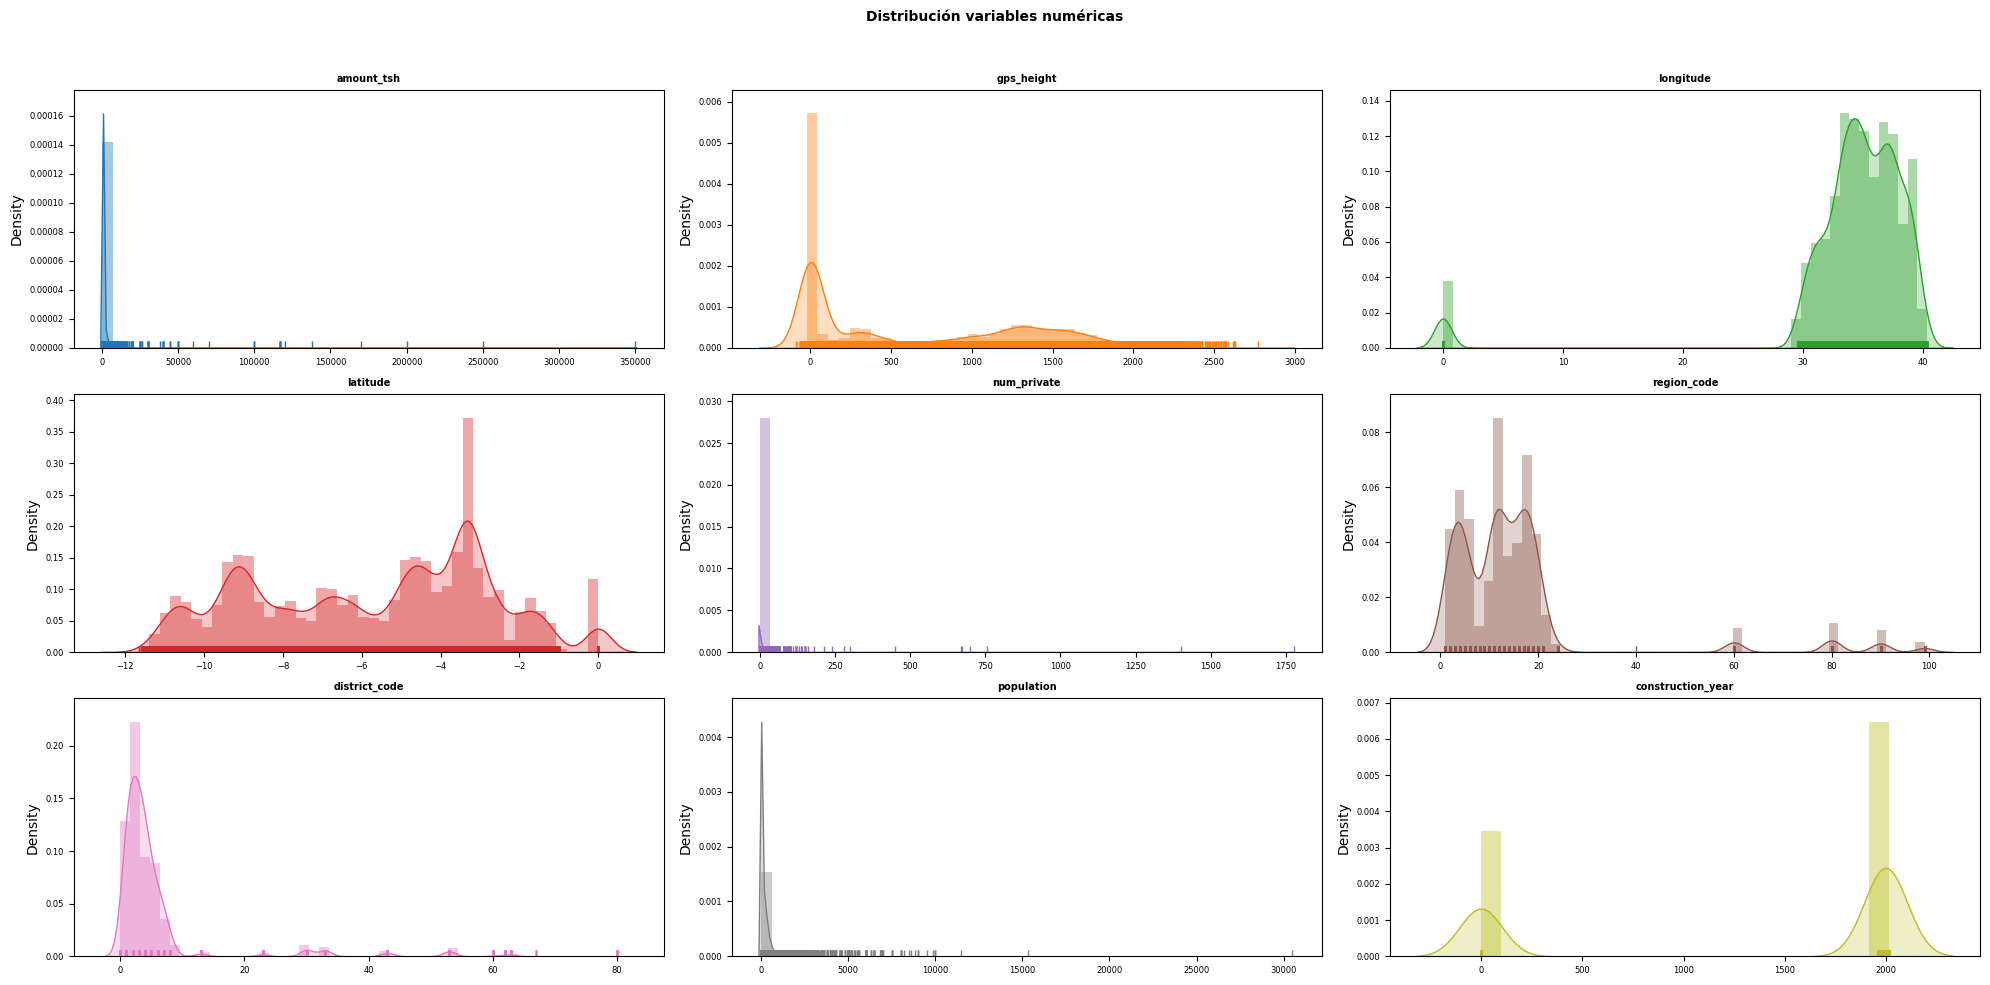

In [124]:
# Variables numéricas

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
axes = axes.flat
columnas_numeric = train_data.select_dtypes(include=['float64', 'int64']).columns
columnas_numeric = columnas_numeric.drop('id')
for i, colum in enumerate(columnas_numeric):
    sns.distplot(train_data[colum], hist= True, rug = True,
                 color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
                 kde_kws = {'shade': True, 'linewidth': 1}, ax  = axes[i] )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

Podemos probar que tal se ven algunas variables con transformaciones logarítmicas.

In [125]:
# Variables categóricas 

def cat_plot(col):
     if col.dtypes == 'object':
        fig = px.bar(col.value_counts())
        #fig = sns.countplot(x=col)
        return(fig)

columnas_cat = train_data.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_cat):
    plot= cat_plot(train_data[colum])
    plot.show()

Eliminamos la variable recorded_by ya que es GeoData y no nos aporta nada en el modelo

In [126]:
train_data = train_data.drop('recorded_by',axis=1)
test = test.drop('recorded_by',axis=1)

Tras observar las distribuciones de las variables, observamos que algunas variables pueden presentar valores atípicos asi que los estudiamos. 

### Valores atípicos


In [127]:
train_data.select_dtypes(include=np.number).apply(lambda x: x.skew())

id                    0.002623
amount_tsh           57.807800
gps_height            0.462402
longitude            -4.191046
latitude             -0.152037
num_private          91.933750
region_code           3.173818
district_code         3.962045
population           12.660714
construction_year    -0.634928
dtype: float64

- Amount_tsh con un 57.80% de asimetría
- num_private con un 91.93 % de asimetría

Observamos la cantidad de ceros que hay en estas variables ya que en las gráficas se observa que hay mucha cantidad.

In [128]:
train_data['amount_tsh'].value_counts(0)

amount_tsh
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
6300.0          1
120000.0        1
138000.0        1
350000.0        1
59.0            1
Name: count, Length: 98, dtype: int64

In [129]:
train_data['num_private'].value_counts(0)

num_private
0       58643
6          81
1          73
5          46
8          46
        ...  
42          1
23          1
136         1
698         1
1402        1
Name: count, Length: 65, dtype: int64

Como podemos observar, la variable num_private tiene un más de un 90% de asimetría de los cuales 58643 unidades tienen valor cero. 
Por tanto, podemos decidir eliminarla. En cuanto a amount podemos probar con una transformación logarítmica.

In [130]:
train_data = train_data.drop('num_private', axis=1)

#### Transformaciones logarítmicas
Para mejorar la asimetría podemos transformar amount_tsh a logaritmo. 

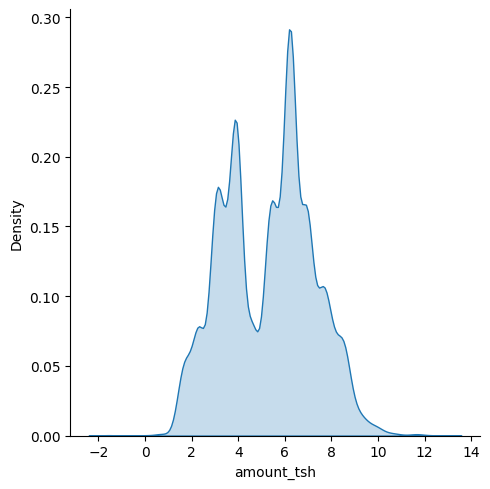

In [131]:
sns.displot(x=np.log(train_data['amount_tsh']), kind="kde", fill=True)


In [132]:
# Añadimos un 1, así evitamos que haya valores infinitos
train_data['amount_tsh']=np.log(train_data['amount_tsh'] + 1)

In [133]:
## Función manual de winsor con clip+quantile 
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))

# clip --> hacer el colapso en cierto percentil

In [134]:
from scipy import stats # Añadimos en este punto para cargar la librería que ahora hace falta

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>6 ## Cambio mad por median_abs_deviation!! 
     
     # Calcular primer cuartil     
     q1 = col.quantile(0.25)  
     # Calcular tercer cuartil  
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

          
# Llamada en modo check
train_data.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))

id
amount_tsh
gps_height
longitude
latitude
region_code
district_code
population
construction_year


,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
0,0.0,0.000000,0.0,3.050505,0.0,0.000000,0.000000,0.000000,0.0
1,0.0,0.005051,0.0,0.000000,0.0,6.065657,6.392256,3.296296,0.0
2,0.0,0.005051,0.0,3.050505,0.0,6.065657,6.392256,3.296296,0.0


In [135]:
imput = train_data[['id','gps_height', 'longitude', 'latitude','region_code','district_code','population','construction_year']]
train_winsor = imput.apply(lambda x: gestiona_outliers(x,clas='winsor'))
train_winsor.apply(lambda x: x.isna().sum()/x.count()*100)


id
gps_height
longitude
latitude
region_code
district_code
population
construction_year


id                   0.0
gps_height           0.0
longitude            0.0
latitude             0.0
region_code          0.0
district_code        0.0
population           0.0
construction_year    0.0
dtype: float64

In [136]:
# Juntar columnas con join
imput_t = train_winsor.join(train_data.select_dtypes(exclude=np.number))
variable = train_data[['amount_tsh']]
imput_wins = imput_t.join(variable)
imput_wins.head(5)

,id,gps_height,longitude,latitude,region_code,district_code,population,construction_year,date_recorded,funder,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh
0,69572,1390,34.938093,-9.856322,11,5,109,1999,2011-03-14,Roman,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,8.699681
1,8776,1399,34.698766,-2.147466,20,2,280,2010,2013-03-06,Grumeti,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0.000000
2,34310,686,37.460664,-3.821329,21,4,250,2009,2013-02-25,Lottery Club,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,3.258097
3,67743,263,38.486161,-11.155298,60,23,58,1986,2013-01-28,Unicef,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0.000000
4,19728,0,31.130847,-1.825359,18,1,0,0,2011-07-13,Action In A,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0.000000


### Valores nulos

In [137]:
#Proporción de missings por variable 
imput_wins.apply(lambda x: x.isna().sum()/imput_wins.shape[0]*100)

id                        0.000000
gps_height                0.000000
longitude                 0.000000
latitude                  0.000000
region_code               0.000000
district_code             0.000000
population                0.000000
construction_year         0.000000
date_recorded             0.000000
funder                    6.122896
installer                 6.153199
wpt_name                  0.003367
basin                     0.000000
subvillage                0.624579
region                    0.000000
lga                       0.000000
ward                      0.000000
public_meeting            5.612795
scheme_management         6.528620
scheme_name              48.501684
permit                    5.144781
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group          0.000000
payment                   0.000000
payment_type              0.000000
water_quality       

In [138]:
imput_wins.isnull().sum()

id                           0
gps_height                   0
longitude                    0
latitude                     0
region_code                  0
district_code                0
population                   0
construction_year            0
date_recorded                0
funder                    3637
installer                 3655
wpt_name                     2
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3334
scheme_management         3878
scheme_name              28810
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source  

In [139]:
#Proporción de missings por observación (como una nueva columna del dataset)
imput_wins['prop_missings'] = imput_wins.apply(lambda x: x.isna().sum()/imput_wins.shape[1]*100,axis=1)

# Valoramos distribución
imput_wins.prop_missings.describe()

count    59400.000000
mean         2.070840
std          2.429723
min          0.000000
25%          0.000000
50%          2.631579
75%          2.631579
max         15.789474
Name: prop_missings, dtype: float64

In [140]:
imput_wins.sort_values(by='prop_missings', ascending=False).head()

,id,gps_height,longitude,latitude,region_code,district_code,population,construction_year,date_recorded,funder,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh,prop_missings
21690,71282,1289,36.189340,-3.422393,2,1,1,0,2013-03-19,NaN,...,unknown,unknown,unknown,unknown,other,unknown,communal standpipe,communal standpipe,0.0,15.789474
27798,65087,1143,36.320944,-2.823900,2,6,1,0,2013-03-19,NaN,...,unknown,unknown,unknown,unknown,other,unknown,hand pump,hand pump,0.0,15.789474
11968,19795,1287,36.760284,-3.388704,2,7,1,0,2013-03-14,NaN,...,unknown,unknown,unknown,unknown,other,unknown,communal standpipe,communal standpipe,0.0,15.789474
13754,52485,1035,36.091621,-3.554980,2,1,1,2000,2013-03-17,NaN,...,unknown,unknown,unknown,machine dbh,borehole,groundwater,other,other,0.0,15.789474
36032,66687,1304,36.900464,-3.112022,2,7,250,0,2013-10-03,NaN,...,unknown,unknown,unknown,spring,spring,groundwater,communal standpipe,communal standpipe,0.0,15.789474


In [141]:
imput_wins = imput_wins.drop('prop_missings',axis=1)

<Axes: >

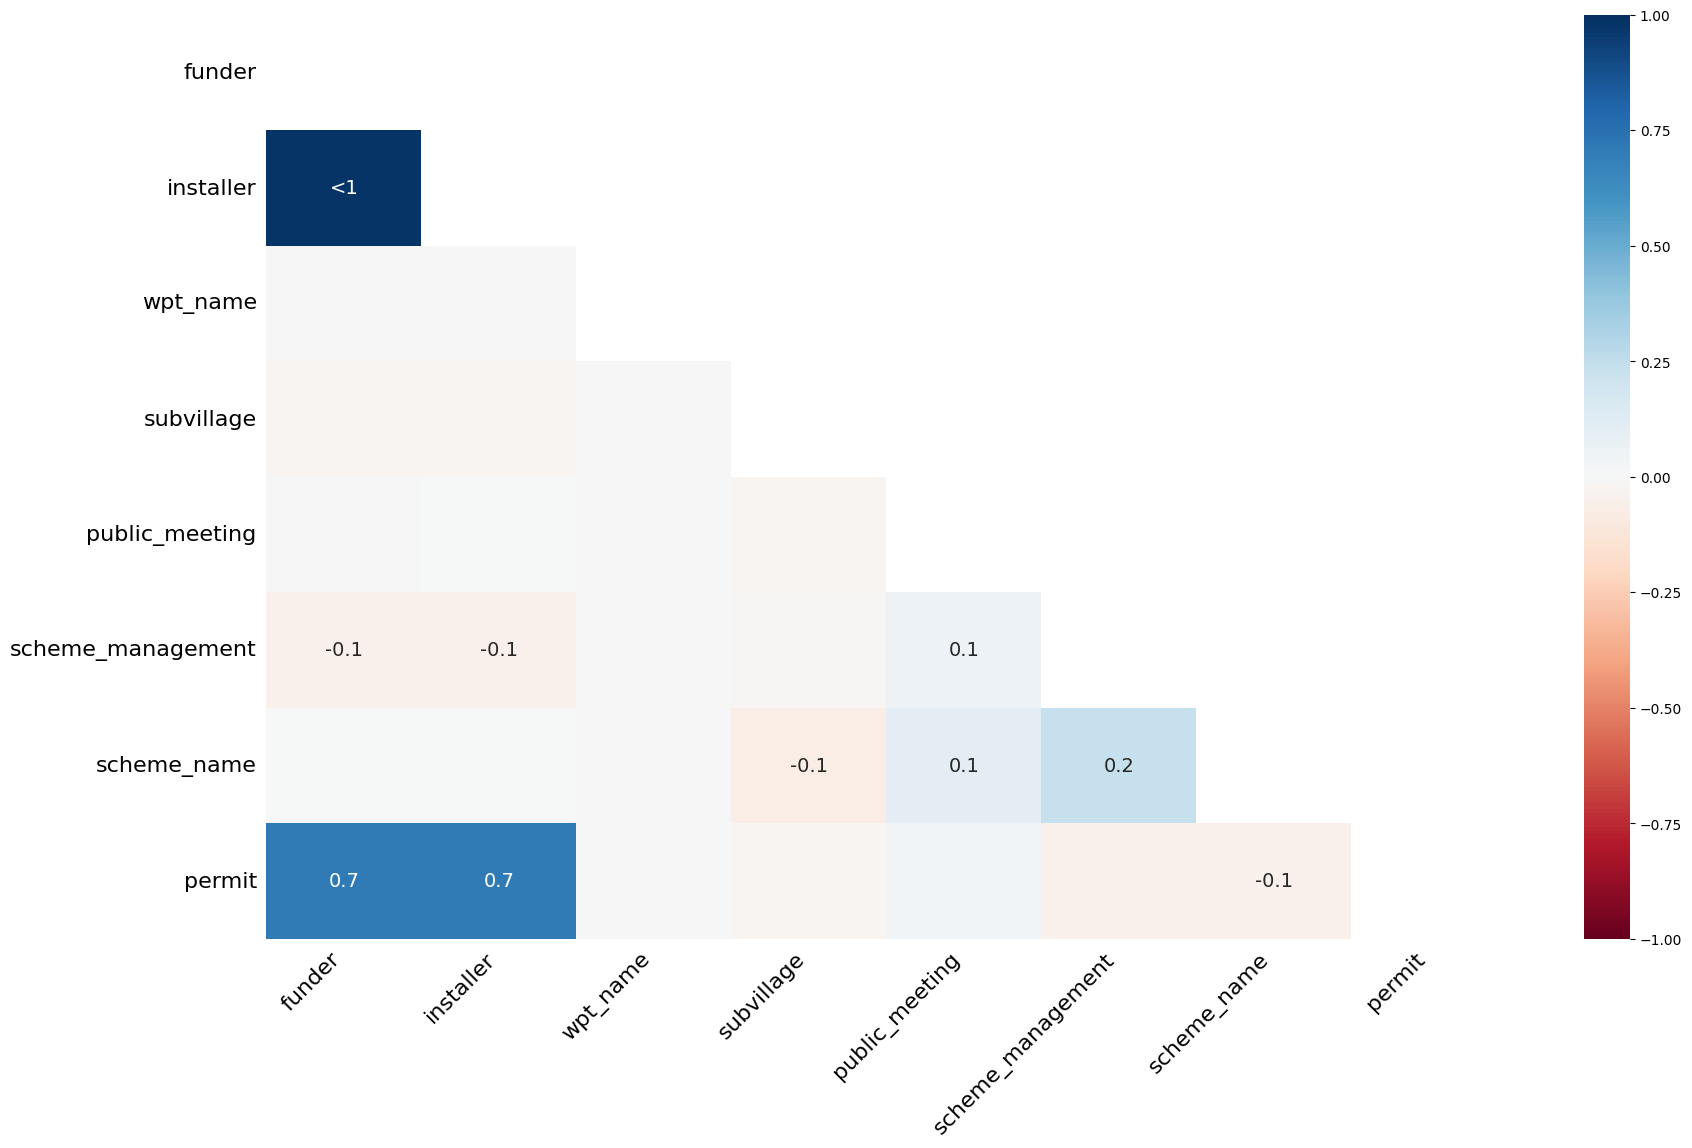

In [142]:
import missingno as msno 
msno.heatmap(imput_wins)

Observamos que la incedencia de scheme_name tiene un 48% de missings, por tanto, la podemos eliminar. Las variables funder e installer tienen una correlación alta entre ellas y con permit, por tanto imputarlas no sería óptimo. 

In [143]:
# Eliminamos scheme_name y sustituimos Nan por unknown en  funder e installer 

imput_wins = imput_wins.drop('scheme_name', axis=1)


imput_wins['funder'] = imput_wins['funder'].fillna('unknown')


imput_wins['installer'] = imput_wins['installer'].fillna('unknown')



In [144]:
imput_wins.apply(lambda x: x.isna().sum()/imput_wins.shape[0]*100)

id                       0.000000
gps_height               0.000000
longitude                0.000000
latitude                 0.000000
region_code              0.000000
district_code            0.000000
population               0.000000
construction_year        0.000000
date_recorded            0.000000
funder                   0.000000
installer                0.000000
wpt_name                 0.003367
basin                    0.000000
subvillage               0.624579
region                   0.000000
lga                      0.000000
ward                     0.000000
public_meeting           5.612795
scheme_management        6.528620
permit                   5.144781
extraction_type          0.000000
extraction_type_group    0.000000
extraction_type_class    0.000000
management               0.000000
management_group         0.000000
payment                  0.000000
payment_type             0.000000
water_quality            0.000000
quality_group            0.000000
quantity      

<Axes: >

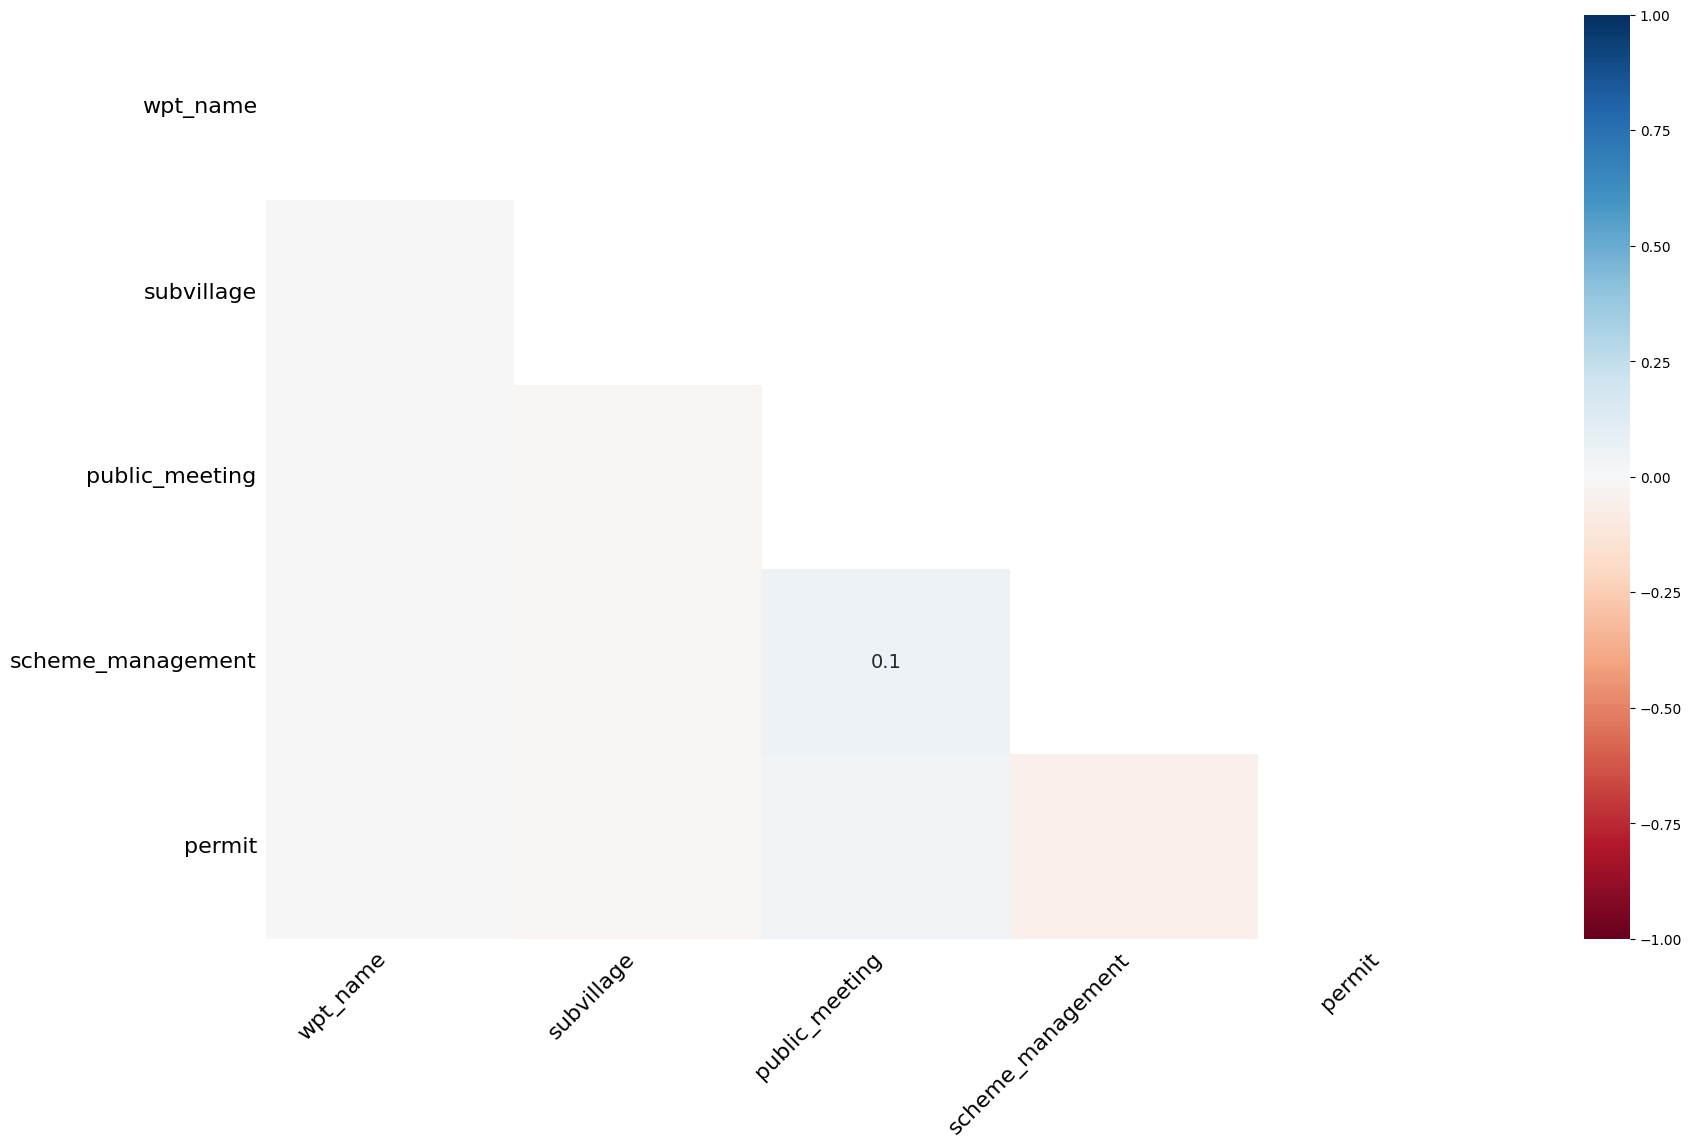

In [145]:
msno.heatmap(imput_wins)

Observamos que la incedencia se ha reducido, las relaciones ahora son muy débiles con un máximo de 0.1 para public_meeting con scheme_management. Por tanto, ya no es preocupante en general. Así que realizaremos la imputación de los datos de cara a mantener la mayor base muestral posible para el ajuste de los futuros modelos a los datos. 

In [146]:
# Separamos el dataset en continuas y categóricas para aplicar los métodos que correspondan 
imput_wins_cont = imput_wins.select_dtypes(include=np.number)
imput_wins_cat = imput_wins.select_dtypes(exclude=np.number)


Al tener missings solo las variables categóricas solo las imputaremos en estas. 

In [147]:
# Moda: Solo nominales
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

In [148]:
imput_wins_moda_imputed = pd.DataFrame(imputer_moda.fit_transform(imput_wins_cat),columns=imput_wins_cat.columns)

imput_wins_moda_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   date_recorded          59400 non-null  object
 1   funder                 59400 non-null  object
 2   installer              59400 non-null  object
 3   wpt_name               59400 non-null  object
 4   basin                  59400 non-null  object
 5   subvillage             59400 non-null  object
 6   region                 59400 non-null  object
 7   lga                    59400 non-null  object
 8   ward                   59400 non-null  object
 9   public_meeting         59400 non-null  object
 10  scheme_management      59400 non-null  object
 11  permit                 59400 non-null  object
 12  extraction_type        59400 non-null  object
 13  extraction_type_group  59400 non-null  object
 14  extraction_type_class  59400 non-null  object
 15  management         

In [149]:
# Datos depurados moda
train_wins_moda = pd.concat([imput_wins_cont,imput_wins_moda_imputed], axis=1)

train_wins_moda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   gps_height             59400 non-null  int64  
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   population             59400 non-null  int64  
 7   construction_year      59400 non-null  int64  
 8   amount_tsh             59400 non-null  float64
 9   date_recorded          59400 non-null  object 
 10  funder                 59400 non-null  object 
 11  installer              59400 non-null  object 
 12  wpt_name               59400 non-null  object 
 13  basin                  59400 non-null  object 
 14  subvillage             59400 non-null  object 
 15  re

In [150]:
# Guardar archivo knn+moda
train_wins_moda.to_csv('TrainDep_winsKnnModa.csv')

## Preprocesado test

Realizaremos los mismos cambios que hemos realizado con test en train

In [151]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

### Valores atípicos y nulos

In [152]:
test.select_dtypes(include=np.number).apply(lambda x: x.skew())

id                   -0.010584
amount_tsh           43.857861
gps_height            0.497094
longitude            -4.173130
latitude             -0.156238
num_private          50.744510
region_code           3.201174
district_code         3.959339
population            8.217148
construction_year    -0.609383
dtype: float64

In [153]:
# eliminamos la variable num_private y hacemos el logaritmo en amount_tsh
test = test.drop('num_private', axis=1)
test['amount_tsh']=np.log(test['amount_tsh'] + 1)

In [154]:
# utilizamos la función gestiona_outliers
imput1 = test[['id','gps_height', 'longitude', 'latitude','region_code','district_code','population','construction_year']]
test_winsor = imput1.apply(lambda x: gestiona_outliers(x,clas='winsor'))
test_winsor.apply(lambda x: x.isna().sum()/x.count()*100)


id
gps_height
longitude
latitude
region_code
district_code
population
construction_year


id                   0.0
gps_height           0.0
longitude            0.0
latitude             0.0
region_code          0.0
district_code        0.0
population           0.0
construction_year    0.0
dtype: float64

In [155]:

# Juntar columnas con join
imput_t1 = test_winsor.join(test.select_dtypes(exclude=np.number))
variable1 = test[['amount_tsh']]
imput_wins1 = imput_t1.join(variable1)
imput_wins1.head(5)

,id,gps_height,longitude,latitude,region_code,district_code,population,construction_year,date_recorded,funder,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh
0,50785,1996,35.290799,-4.059696,21,3,321,2012,2013-02-04,Dmdd,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,0.000000
1,51630,1569,36.656709,-3.309214,2,2,300,2000,2013-02-04,Government Of Tanzania,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,0.000000
2,17168,1567,34.767863,-5.004344,13,2,500,2010,2013-02-01,NaN,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,0.000000
3,45559,267,38.058046,-9.418672,60,23,250,1987,2013-01-22,Finn Water,...,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,0.000000
4,49871,1260,35.006123,-10.950412,10,3,60,2000,2013-03-27,Bruder,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,6.216606


In [156]:
#Proporción de missings por variable 
imput_wins1.apply(lambda x: x.isna().sum()/imput_wins1.shape[0]*100)

id                        0.000000
gps_height                0.000000
longitude                 0.000000
latitude                  0.000000
region_code               0.000000
district_code             0.000000
population                0.000000
construction_year         0.000000
date_recorded             0.000000
funder                    5.858586
installer                 5.905724
wpt_name                  0.000000
basin                     0.000000
subvillage                0.666667
region                    0.000000
lga                       0.000000
ward                      0.000000
public_meeting            5.528620
scheme_management         6.525253
scheme_name              48.767677
permit                    4.962963
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group          0.000000
payment                   0.000000
payment_type              0.000000
water_quality       

In [157]:
# Eliminamos scheme_name y sustituimos Nan por unknown en  funder e installer 

imput_wins1 = imput_wins1.drop('scheme_name', axis=1)


imput_wins1['funder'] = imput_wins1['funder'].fillna('unknown')


imput_wins1['installer'] = imput_wins1['installer'].fillna('unknown')

In [158]:
# Separamos el dataset en continuas y categóricas para aplicar los métodos que correspondan 
imput_wins_cont1 = imput_wins1.select_dtypes(include=np.number)
imput_wins_cat1 = imput_wins1.select_dtypes(exclude=np.number)


In [159]:
imput_wins_moda_imputed1 = pd.DataFrame(imputer_moda.fit_transform(imput_wins_cat1),columns=imput_wins_cat1.columns)

imput_wins_moda_imputed1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   date_recorded          14850 non-null  object
 1   funder                 14850 non-null  object
 2   installer              14850 non-null  object
 3   wpt_name               14850 non-null  object
 4   basin                  14850 non-null  object
 5   subvillage             14850 non-null  object
 6   region                 14850 non-null  object
 7   lga                    14850 non-null  object
 8   ward                   14850 non-null  object
 9   public_meeting         14850 non-null  object
 10  scheme_management      14850 non-null  object
 11  permit                 14850 non-null  object
 12  extraction_type        14850 non-null  object
 13  extraction_type_group  14850 non-null  object
 14  extraction_type_class  14850 non-null  object
 15  management         

In [160]:
# Datos depurados moda
test_wins_moda = pd.concat([imput_wins_cont1,imput_wins_moda_imputed1], axis=1)

test_wins_moda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   gps_height             14850 non-null  int64  
 2   longitude              14850 non-null  float64
 3   latitude               14850 non-null  float64
 4   region_code            14850 non-null  int64  
 5   district_code          14850 non-null  int64  
 6   population             14850 non-null  int64  
 7   construction_year      14850 non-null  int64  
 8   amount_tsh             14850 non-null  float64
 9   date_recorded          14850 non-null  object 
 10  funder                 14850 non-null  object 
 11  installer              14850 non-null  object 
 12  wpt_name               14850 non-null  object 
 13  basin                  14850 non-null  object 
 14  subvillage             14850 non-null  object 
 15  re

In [161]:
# Guardar archivo knn+moda
test_wins_moda.to_csv('testDep_winsKnnModa.csv')

## Tratamiento variables categóricas

In [162]:
# Creamos un dataframe con los datos depurados, winsorizados e imputados
df = train_wins_moda

##### Transformamos la variable date_recorded a mes, año y día y agrupamos variables similares

In [163]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['mes'] = df['date_recorded'].dt.month
df['año'] = df['date_recorded'].dt.year
df['dia'] = df['date_recorded'].dt.day

df = df.drop('date_recorded',axis=1)


In [164]:
# transformamos también en test
test_wins_moda['date_recorded'] = pd.to_datetime(test_wins_moda['date_recorded'])
test_wins_moda['mes'] = test_wins_moda['date_recorded'].dt.month
test_wins_moda['año'] = test_wins_moda['date_recorded'].dt.year
test_wins_moda['dia'] = test_wins_moda['date_recorded'].dt.day

test_wins_moda = test_wins_moda.drop('date_recorded',axis=1)

In [165]:
# observemos la variable source
df['source'].value_counts()

source
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: count, dtype: int64

In [166]:
df['source_type'].value_counts()

source_type
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: count, dtype: int64

In [167]:
df['source_class'].value_counts()

source_class
groundwater    45794
surface        13328
unknown          278
Name: count, dtype: int64

Observamos que source_type es una variable redundante ya que explica lo mismo en la variable source.

In [168]:
# Eliminamos la variable 
df = df.drop('source_type',axis=1)

In [169]:
test_wins_moda = test_wins_moda.drop('source_type',axis=1)

Creamos una variable conjunta para source

In [170]:
df['source_todo'] = df['source'] + df['source_class']
df = df.drop(['source','source_class'], axis=1)

In [171]:
test_wins_moda['source_todo'] = test_wins_moda['source'] + test_wins_moda['source_class']
test_wins_moda =test_wins_moda.drop(['source','source_class'], axis=1)

In [172]:
df['source_todo']

0                  springgroundwater
1        rainwater harvestingsurface
2                         damsurface
3             machine dbhgroundwater
4        rainwater harvestingsurface
                    ...             
59395              springgroundwater
59396                   riversurface
59397         machine dbhgroundwater
59398        shallow wellgroundwater
59399        shallow wellgroundwater
Name: source_todo, Length: 59400, dtype: object

In [173]:
df['payment'].value_counts()

payment
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: count, dtype: int64

In [174]:
df['payment_type'].value_counts()

payment_type
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: count, dtype: int64

Observamos que tiene las mismas categorías y las mismas cantidades. Podemos eliminar una. 

In [175]:
df = df.drop('payment', axis=1)

In [176]:
test_wins_moda = test_wins_moda.drop('payment', axis=1)

In [177]:
df['waterpoint_type'].value_counts()

waterpoint_type
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: count, dtype: int64

In [178]:
df['waterpoint_type_group'].value_counts()

waterpoint_type_group
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: count, dtype: int64

Conservar ambos seria redundante, en este caso nos quedamos con waterpoint_type ya que tiene una categoría más y su cantidad no perjudica el modelo. 

In [179]:
df = df.drop('waterpoint_type_group', axis=1)

In [180]:
test_wins_moda = test_wins_moda .drop('waterpoint_type_group', axis=1)

In [181]:
df['management'].value_counts()

management
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: count, dtype: int64

In [182]:
df['management_group'].value_counts()

management_group
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: count, dtype: int64

Juntamos ambas variables.

In [183]:
df['management_todo'] = df['management'] + df['management_group']

df = df.drop(['management','management_group'], axis=1)

In [184]:
test_wins_moda['management_todo'] = test_wins_moda['management'] + test_wins_moda['management_group']

test_wins_moda = test_wins_moda.drop(['management','management_group'], axis=1)

In [185]:
df['water_quality'].value_counts()

water_quality
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: count, dtype: int64

In [186]:
df['quality_group'].value_counts()

quality_group
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: count, dtype: int64

In [187]:
df['quality'] = df['water_quality'] + df['quality_group']

df = df.drop(['water_quality','quality_group'], axis=1)


In [188]:
test_wins_moda['quality'] =test_wins_moda['water_quality'] + test_wins_moda['quality_group']

test_wins_moda = test_wins_moda.drop(['water_quality','quality_group'], axis=1)

In [189]:
df['extraction_type'].value_counts()

extraction_type
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: count, dtype: int64

In [190]:
df['extraction_type_class'].value_counts()

extraction_type_class
gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: count, dtype: int64

In [191]:
df['extraction_type_group'].value_counts()

extraction_type_group
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: count, dtype: int64

In [192]:
df['extraction_todo'] = df['extraction_type'] + df['extraction_type_class'] + df['extraction_type_group']

df = df.drop(['extraction_type','extraction_type_class','extraction_type_group'], axis=1)


In [193]:
test_wins_moda['extraction_todo'] = test_wins_moda['extraction_type'] + test_wins_moda['extraction_type_class'] + test_wins_moda['extraction_type_group']

test_wins_moda = test_wins_moda.drop(['extraction_type','extraction_type_class','extraction_type_group'], axis=1)


In [194]:
df['quantity'].value_counts()

quantity
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

In [195]:
df['quantity_group'].value_counts()

quantity_group
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

Como ambas variables, tienen la misma información, eliminamos una. 

In [196]:
df = df.drop('quantity_group',axis=1)

In [197]:
test_wins_moda = test_wins_moda.drop('quantity_group',axis=1)

##### Codificación

Cambiamos public_meeting y permit a booleano

In [198]:
df['public_meeting'] = df['public_meeting'].replace(True,1)
df['public_meeting'] = df['public_meeting'].replace(False,0)

In [199]:
test_wins_moda['public_meeting'] =test_wins_moda['public_meeting'].replace(True,1)
test_wins_moda['public_meeting'] = test_wins_moda['public_meeting'].replace(False,0)

In [200]:
df['permit'] = df['permit'].replace(True,1)
df['permit'] = df['permit'].replace(False,0)

In [201]:
test_wins_moda['permit'] = test_wins_moda['permit'].replace(True,1)
test_wins_moda['permit'] = test_wins_moda['permit'].replace(False,0)

In [202]:
df.nunique()

id                   59400
gps_height            2428
longitude            57516
latitude             57517
region_code             24
district_code           11
population             709
construction_year       55
amount_tsh              98
funder                1897
installer             2145
wpt_name             37399
basin                    9
subvillage           19287
region                  21
lga                    125
ward                  2092
public_meeting           2
scheme_management       11
permit                   2
payment_type             7
quantity                 5
waterpoint_type          7
mes                     12
año                      5
dia                     31
source_todo             10
management_todo         12
quality                  8
extraction_todo         18
dtype: int64

Utilizamos la función de count encoder en el resto de las variables categóricas. Ya que así reflejamos la frecuencia con la que cada categoría aparece en los datos. 

In [203]:
count_enc = CountEncoder(cols=None)

In [204]:
count_enc.fit(df)

CountEncoder(cols=['funder', 'installer', 'wpt_name', 'basin', 'subvillage',
                   'region', 'lga', 'ward', 'scheme_management', 'payment_type',
                   'quantity', 'waterpoint_type', 'source_todo',
                   'management_todo', 'quality', 'extraction_todo'],
             combine_min_nan_groups=True)

In [205]:
count_enc.fit(test_wins_moda)

CountEncoder(cols=['funder', 'installer', 'wpt_name', 'basin', 'subvillage',
                   'region', 'lga', 'ward', 'scheme_management', 'payment_type',
                   'quantity', 'waterpoint_type', 'source_todo',
                   'management_todo', 'quality', 'extraction_todo'],
             combine_min_nan_groups=True)

In [206]:
count_enc.cols

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'scheme_management',
 'payment_type',
 'quantity',
 'waterpoint_type',
 'source_todo',
 'management_todo',
 'quality',
 'extraction_todo']

In [207]:
df_enc = count_enc.transform(df)

In [208]:
test_enc = count_enc.transform(test_wins_moda)

In [209]:
df_enc.head()

,id,gps_height,longitude,latitude,region_code,district_code,population,construction_year,amount_tsh,funder,...,payment_type,quantity,waterpoint_type,mes,año,dia,source_todo,management_todo,quality,extraction_todo
0,69572,1390,34.938093,-9.856322,11,5,109,1999,8.699681,61.0,...,928,8336,7106,3,2011,14,4195,10117,12687,6483.0
1,8776,1399,34.698766,-2.147466,20,2,280,2010,0.000000,11.0,...,6364,3767,7106,3,2013,6,568,1593,12687,6483.0
2,34310,686,37.460664,-3.821329,21,4,250,2009,3.258097,1.0,...,2281,8336,1508,2,2013,25,184,10117,12687,6483.0
3,67743,263,38.486161,-11.155298,60,23,58,1986,0.000000,267.0,...,6364,1536,1508,1,2013,28,2747,10117,12687,1218.0
4,19728,0,31.130847,-1.825359,18,1,0,0,0.000000,0.0,...,6364,1025,7106,7,2011,13,568,239,12687,6483.0


In [210]:
test_enc.head()

,id,gps_height,longitude,latitude,region_code,district_code,population,construction_year,amount_tsh,funder,...,payment_type,quantity,waterpoint_type,mes,año,dia,source_todo,management_todo,quality,extraction_todo
0,50785,1996,35.290799,-4.059696,21,3,321,2012,0.000000,51,...,6364,1025,1630,2,2013,4,568,461,12687,1672
1,51630,1569,36.656709,-3.309214,2,2,300,2000,0.000000,2215,...,6364,3767,7106,2,2013,4,4195,10117,12687,6483
2,17168,1567,34.767863,-5.004344,13,2,500,2010,0.000000,870,...,6364,3767,1630,2,2013,1,568,10117,12687,1672
3,45559,267,38.058046,-9.418672,60,23,250,1987,0.000000,8,...,1992,1536,1630,1,2013,22,4316,10117,12687,1672
4,49871,1260,35.006123,-10.950412,10,3,60,2000,6.216606,9,...,2097,8336,7106,3,2013,27,4195,755,12687,6483


### Codificación de la variable objetivo categórica

In [211]:
y_enc = labels.copy()

In [212]:
y_enc['status_group'] = LabelEncoder().fit_transform(y_enc['status_group'])

In [213]:
y_enc.head()

,id,status_group
0,69572,0
1,8776,0
2,34310,0
3,67743,2
4,19728,0


## Correlación de las variables con la objetivo

In [214]:
combinado = pd.merge(df_enc, y_enc, on='id')

In [215]:
df_enc.set_index('id', inplace=True)

In [216]:
combinado1 = pd.merge(df_enc, labels, on='id')

In [217]:
corr = abs(combinado.corr())
corr[['status_group']].sort_values(by = 'status_group',ascending = False).style.background_gradient()

,status_group
status_group,1.000000
quantity,0.298111
waterpoint_type,0.250535
amount_tsh,0.213436
payment_type,0.171031
ward,0.156018
region,0.146195
lga,0.137584
extraction_todo,0.130877
quality,0.128305


In [218]:
list(corr[['status_group']].sort_values(by = 'status_group',ascending = False).index)

['status_group',
 'quantity',
 'waterpoint_type',
 'amount_tsh',
 'payment_type',
 'ward',
 'region',
 'lga',
 'extraction_todo',
 'quality',
 'management_todo',
 'funder',
 'gps_height',
 'scheme_management',
 'region_code',
 'wpt_name',
 'public_meeting',
 'district_code',
 'basin',
 'construction_year',
 'permit',
 'dia',
 'source_todo',
 'mes',
 'subvillage',
 'año',
 'latitude',
 'population',
 'installer',
 'longitude',
 'id']

Utilizamos el combinado con la variable objetivo codificada para realizar las correlaciones y el combinado1 sin la codificación de la variable objetivo para construir el modelo 

## Construcción de un modelo análitico de clasificación que sea capaz de predecir cuando el punto de agua es funcional,necesita reparación o no es funcional  

In [219]:
combinado1.set_index('id', inplace=True)

In [220]:
test_enc.set_index('id', inplace=True)

In [221]:
X_train, X_test, y_train, y_test = train_test_split (combinado1.drop('status_group',axis=1), 
                                                     combinado1['status_group'],
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     stratify=combinado1['status_group']
                                                     )


In [222]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47520 entries, 1027 to 47611
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         47520 non-null  int64  
 1   longitude          47520 non-null  float64
 2   latitude           47520 non-null  float64
 3   region_code        47520 non-null  int64  
 4   district_code      47520 non-null  int64  
 5   population         47520 non-null  int64  
 6   construction_year  47520 non-null  int64  
 7   amount_tsh         47520 non-null  float64
 8   funder             47520 non-null  float64
 9   installer          47520 non-null  float64
 10  wpt_name           47520 non-null  float64
 11  basin              47520 non-null  int64  
 12  subvillage         47520 non-null  float64
 13  region             47520 non-null  int64  
 14  lga                47520 non-null  int64  
 15  ward               47520 non-null  float64
 16  public_meeting     47520

# Random forest

Nos hemos decidido por este random forest con estas características ya que es el que obtiene mayor puntuación (0.8153)
Ya que probando otros tipos de modelos como el XGboost obtenemos una puntuación menor de 0.8045.
Hemos intentado realizar también un balanceo de datos pero el score se reduce a 0.7905 y la selección de variables nos da 0.8117.

In [223]:
modelRF = RandomForestClassifier(n_estimators=400, random_state=0,max_depth=20)

classifier3 = modelRF.fit(X_train, y_train)
pred3 = classifier3.predict(X_test)

#0.8153

In [224]:
modelo2 = classifier3.predict(test_enc)
modelo2 = (pd.DataFrame(modelo2,columns=['status_group'],index=test_enc.index))
modelo2.sort_values(by=['status_group'],ascending=False,axis=0,inplace=True)

In [225]:
submission = submission.drop('status_group',axis=1)

In [226]:
submission_3 = pd.merge(submission,modelo2,on='id')

In [227]:
submission_3

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional
...,...
39307,non functional
18990,functional
28749,functional


In [228]:
submission_3.to_csv('submission3.csv', index=True)

In [229]:
combinado.set_index('id', inplace=True)

# Features importance

Las variables importantes para el best score 0.8153

Text(0.5, 0, 'Random Forest Feature Importance')

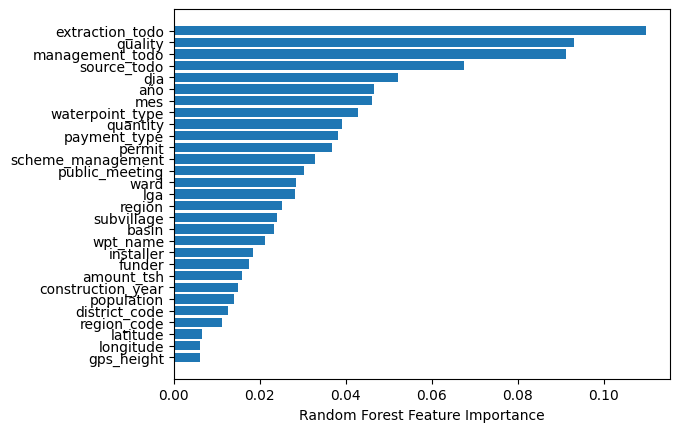

In [230]:
sorted_idx = classifier3.feature_importances_.argsort()
plt.barh(X_train.columns, classifier3.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

<Axes: >

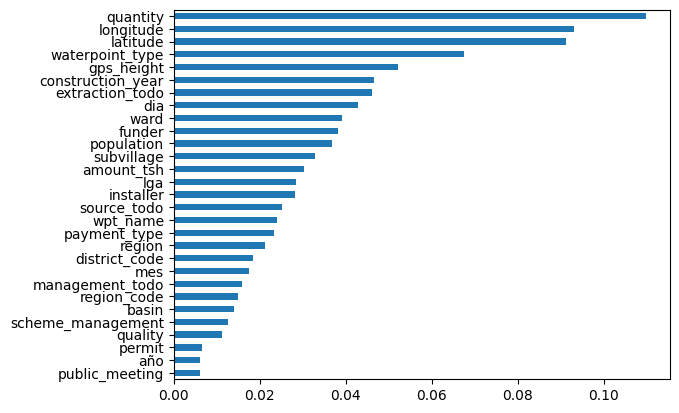

In [231]:
feat_importances = pd.Series(classifier3.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')

In [232]:
imp = {}
for i in range(len(X_train.columns)):
    imp[X_train.columns[i]] = [classifier3.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(10).style.background_gradient()

,Importance
quantity,0.109900
longitude,0.092987
latitude,0.091281
waterpoint_type,0.067499
gps_height,0.052057
construction_year,0.046528
extraction_todo,0.046075
dia,0.042944
ward,0.039231
funder,0.038215


Podemos deducir que las variables más importantes del modelo son:
- La cantidad de agua del punto de agua
- Las coordenas del punto de agua (longitud y latitud)
- El tipo de punto de agua
- La altitud del pozo